# Data Science  - Unit 2.1.3
Name: Michael Luo

Date: 2022/10/28


In [ ]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Applied-Modeling/master/data/'
    # !pip install category_encoders==2.* #locks to version 2+

# If you're working locally:
else:
    DATA_PATH = '../data/'

# Module Project: Ridge Regression

For this project, you'll return to the Tribecca Condo dataset. But this time, you'll look at the _entire_ dataset and try to predict property sale prices.

The [NYC Department of Finance](https://www1.nyc.gov/site/finance/taxes/property-rolling-sales-data.page) has a glossary of property sales terms and NYC Building Class Code Descriptions. The data comes from the [NYC OpenData](https://data.cityofnewyork.us/browse?q=NYC%20calendar%20sales) portal.

## Directions

The tasks for this project are the following:

- **Task 1:** Import `csv` file using `wrangle` function.
- **Task 2:** Conduct exploratory data analysis (EDA), and modify `wrangle` function to engineer two subset your dataset to one-family dwellings whose price is between \\$100,000 and \\$2,000,000.
- **Task 3:** Split data into feature matrix `X` and target vector `y`.
- **Task 4:** Split feature matrix `X` and target vector `y` into training and test sets.
- **Task 5:** Establish the baseline mean absolute error for your dataset.
- **Task 6:** Build and train a `OneHotEncoder`, and transform `X_train` and `X_test`.
- **Task 7:** Build and train a `LinearRegression` model.
- **Task 8:** Build and train a `Ridge` model.
- **Task 9:** Calculate the training and test mean absolute error for your `LinearRegression` model.
- **Task 10:** Calculate the training and test mean absolute error for your `Ridge` model.
- **Task 11:** Create a horizontal bar chart showing the 10 most influencial features for your `Ridge` model. 

**Note**

You should limit yourself to the following libraries for this project:

- `category_encoders`
- `matplotlib`
- `pandas`
- `sklearn`

In [ ]:
import pandas as pd
import numpy as np

#processing
# from category_encoders import OneHotEncoder
# from sklearn.preprocessing import OneHotEncoder
from category_encoders import OneHotEncoder #better for now, sklearn OHE has to be used with column transformer. otherwise it will transform everything passed in the fitting step INCLUDING numeric dtypes

#modeling
from sklearn.linear_model import LinearRegression, Ridge

#metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error

#visualization
import seaborn as sns
import matplotlib.pyplot as plt


# I. Wrangle Data

In [ ]:
def wrangle(filepath):
    # Import csv file
    cols = ['BOROUGH', 'NEIGHBORHOOD',
            'BUILDING CLASS CATEGORY', 'GROSS SQUARE FEET',  
            'YEAR BUILT', 'SALE PRICE', 'SALE DATE']
    df = pd.read_csv(filepath, usecols=cols, parse_dates=True, index_col='SALE DATE')

    #drop null values
    # df = df.dropna(axis=0)

    #Filter by 1 family dwellings only
    df = df[df['BUILDING CLASS CATEGORY'] == '01 ONE FAMILY DWELLINGS'].drop(columns=['BUILDING CLASS CATEGORY'])
    
    #Fix datatypes for BOROUGH, SALE PRICE
    df['BOROUGH'] = df['BOROUGH'].astype('object')
    df['SALE PRICE'] = df['SALE PRICE'].str.replace('\D+', '', regex=True).astype('float')
    
    #Remove rows with bad data
    for col in df.select_dtypes('number').columns: #iterate through numerical features
      df = df[df[col] > 0] #remove rows with bad data
    
    df = df[(df['SALE PRICE'] >= 100000) & (df['SALE PRICE'] <= 2000000) ]

    return df

filepath = DATA_PATH+'condos/NYC_Citywide_Rolling_Calendar_Sales.csv'

**Task 1:** Use the above `wrangle` function to import the `NYC_Citywide_Rolling_Calendar_Sales.csv` file into a DataFrame named `df`.

In [ ]:
df = wrangle(filepath)

In [ ]:
df.head(n=3)

,BOROUGH,NEIGHBORHOOD,GROSS SQUARE FEET,YEAR BUILT,SALE PRICE
SALE DATE,,,,,
2019-01-01,3,OCEAN PARKWAY-NORTH,1325.0,1930.0,550000.0
2019-01-01,4,QUEENS VILLAGE,2001.0,1940.0,200000.0
2019-01-02,2,PELHAM PARKWAY SOUTH,2043.0,1925.0,810000.0


**Task 2:** Modify the above `wrangle` function so that:

- The column `'SALE DATE'` becomes the `DatetimeIndex`.
- The dtype for the `'BOROUGH'` column is `object`, not `int`.
- The dtype for the `'SALE PRICE'` column is `int`, not `object`.
- The dataset includes only one-family dwellings (`BUILDING CLASS CATEGORY == '01 ONE FAMILY DWELLINGS'`).
- The dataset includes only properties whose sale price is between \\$100,000 and \\$2,000,000.

In [ ]:
# Perform your exploratory data analysis here and
# modify the wrangle function above
print(df.info())
display(df.nunique())
display(df.describe())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3123 entries, 2019-01-01 to 2019-04-30
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   BOROUGH            3123 non-null   object 
 1   NEIGHBORHOOD       3123 non-null   object 
 2   GROSS SQUARE FEET  3123 non-null   float64
 3   YEAR BUILT         3123 non-null   float64
 4   SALE PRICE         3123 non-null   float64
dtypes: float64(3), object(2)
memory usage: 146.4+ KB
None


BOROUGH                 5
NEIGHBORHOOD          184
GROSS SQUARE FEET    1050
YEAR BUILT             88
SALE PRICE            991
dtype: int64

,GROSS SQUARE FEET,YEAR BUILT,SALE PRICE
count,3123.000000,3123.000000,3.123000e+03
mean,1489.013449,1943.788345,6.317376e+05
std,565.625566,26.805962,2.966288e+05
min,280.000000,1890.000000,1.000000e+05
25%,1152.000000,1925.000000,4.500000e+05
50%,1364.000000,1940.000000,5.700000e+05
75%,1690.500000,1955.000000,7.600000e+05
max,7875.000000,2018.000000,2.000000e+06


# II. Split Data

**Task 3:** Split your dataset into the feature matrix `X` and the target vector `y`. You want to predict `'SALE_PRICE'`.

In [ ]:
# df = df.drop(columns='NEIGHBORHOOD')

In [ ]:
target = 'SALE PRICE'
X = df.drop(columns=[target])
y = df[target]

**Task 4:** Split `X` and `y` into a training set (`X_train`, `y_train`) and a test set (`X_test`, `y_test`).

- Your training set should include data from January to March 2019. 
- Your test set should include data from April 2019.

In [ ]:
#check range of datetimeindex
# print(df.index.max(), df.index.min())
  #ranges from Jan 2019 to april 2019

mask = df.index < '2019-4'

In [ ]:
X_train, y_train = X[mask], y[mask]
X_test, y_test = X[~mask], y[~mask]

In [ ]:
#check shapes of training and testing data
print (X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(2486, 4) (637, 4)
(2486,) (637,)


# III. Establish Baseline

**Task 5:** Since this is a **regression** problem, you need to calculate the baseline mean absolute error for your model.

In [ ]:

y_pred_baseline = [y.mean()] * len(y)
baseline_mae = mean_absolute_error(y, y_pred_baseline)

print('Baseline MAE:', baseline_mae)

Baseline MAE: 217341.38911522648


# IV. Build Model 

**Task 6:** Build and train a `OneHotEncoder` and then use it to transform `X_train` and `X_test`.

In [ ]:
#ENCODING FOR LinearRegression
#n-1 variables for regression, but we have new categories unseen in the dataset
# ohe = OneHotEncoder(drop='first', handle_unknown='ignore') 

ohe = OneHotEncoder(use_cat_names=True) #using category_encoders ohe. by default, it handles missing values & unknown ones

XT_train= ohe.fit_transform(X_train) #XT_train is a df, not an np array
XT_test= ohe.transform(X_test)


#If we include neighborhood column, unseen categories when fitting testing data set; cardinality too high for linear regression
#Found unknown categories ['HARLEM-CENTRAL', 'BEDFORD PARK/NORWOOD', 'KENSINGTON', 'AIRPORT LA GUARDIA', 'SPRING CREEK', 'SEAGATE', 'WILLIAMSBURG-EAST'] in column 1 during transform

**Task 7:** Build and train a `LinearRegression` model named `model_lr`. Remember to train your model using your _transformed_ feature matrix.

In [ ]:
model_lr = LinearRegression()

model_lr.fit(XT_train, y_train)

LinearRegression()

**Task 8:** Build and train a `Ridge` model named `model_r`. Remember to train your model using your _transformed_ feature matrix.

In [ ]:
model_r = Ridge(alpha=2.45)

model_r.fit(XT_train, y_train)

Ridge(alpha=2.45)

# V. Check Metrics

**Task 9:** Check the training and test metrics for `model_lr`.

In [ ]:
training_mae_lr = mean_absolute_error(y_train, model_lr.predict(XT_train))
test_mae_lr = mean_absolute_error(y_test, model_lr.predict(XT_test))

print('Linear Training MAE:', training_mae_lr)
print('Linear Test MAE:', test_mae_lr)
print(f'Reference baseline MAE: {baseline_mae}')

Linear Training MAE: 126679.40547063555
Linear Test MAE: 3065212130593.49
Reference baseline MAE: 217341.38911522648


**Task 10:** Check the training and test metrics for `model_r`.

In [ ]:
training_mae_r = mean_absolute_error(y_train, model_r.predict(XT_train))
test_mae_r = mean_absolute_error(y_test, model_r.predict(XT_test))
print('Ridge Training MAE:', training_mae_r)
print('Ridge Test MAE:', test_mae_r)

Ridge Training MAE: 125750.93991102309
Ridge Test MAE: 143490.6897682925


**Stretch Goal:** Calculate the training and test $R^2$ scores `model_r`.

In [ ]:
# Caculate R^2 score
print(f'Ridge training r^2 score: {model_r.score(XT_train, y_train)}')
print(f'Ridge testing r^2 score: {model_r.score(XT_test, y_test)}')

# Caculate R^2 score
print(f'\nLR training r^2 score: {model_lr.score(XT_train, y_train)}')
print(f'LR testing r^2 score: {model_lr.score(XT_test, y_test)}')

Ridge training r^2 score: 0.6033250109211454
Ridge testing r^2 score: 0.4698795027283169

LR training r^2 score: 0.621291576266535
LR testing r^2 score: -1.6102873726765744e+16


# IV. Communicate Results

**Task 11:** Create a horizontal barchart that plots the 10 most important coefficients for `model_r`, sorted by absolute value. Your figure should look like our example from class:

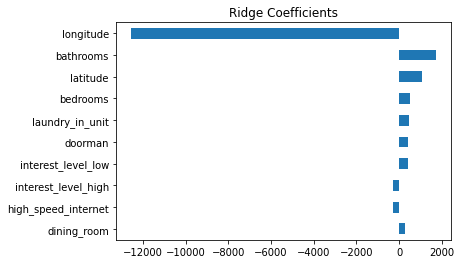

**Note:** Your figure shouldn't be identical to the one above. Your model will have different coefficients since it's been trained on different data. Only the formatting should be the same.

In [ ]:
len(model_r.coef_), len(model_lr.coef_)

(184, 184)

In [ ]:
df_coefs = pd.DataFrame(data={'Ridge Coef': model_r.coef_, 'LR Coef': model_lr.coef_}, index=model_r.feature_names_in_).abs().sort_values(by='Ridge Coef', ascending=False).head(n=10)
df_coefs

,Ridge Coef,LR Coef
NEIGHBORHOOD_WINDSOR TERRACE,395990.995842,1.546529e+14
NEIGHBORHOOD_FOREST HILLS,386156.859989,3.225520e+13
NEIGHBORHOOD_PARK SLOPE SOUTH,367311.606930,1.546529e+14
NEIGHBORHOOD_EAST NEW YORK,353525.927298,1.546529e+14
NEIGHBORHOOD_GREENPOINT,320932.655123,1.546529e+14
NEIGHBORHOOD_CANARSIE,301116.174613,1.546529e+14
NEIGHBORHOOD_ARVERNE,298775.958722,3.225520e+13
NEIGHBORHOOD_PROSPECT HEIGHTS,293608.668521,1.546529e+14
NEIGHBORHOOD_FLATBUSH-LEFFERTS GARDEN,290625.007772,1.546529e+14
NEIGHBORHOOD_HAMMELS,286198.525398,3.225520e+13


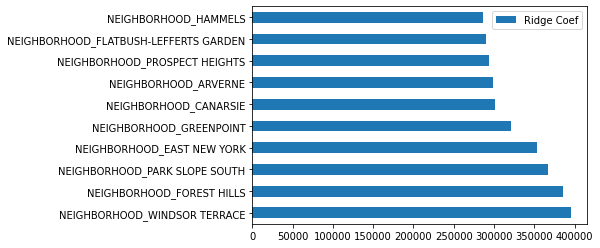

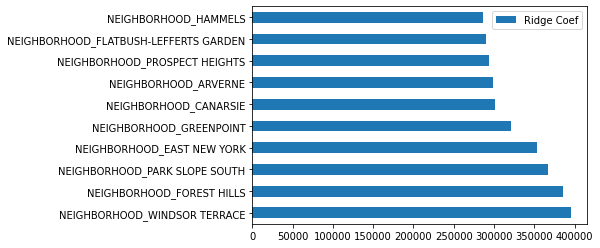

In [ ]:
#Practice visualization

#METHOD 1: dataframe.plot.barh
df_coefs.plot.barh(y='Ridge Coef')
  #y is dependent variable, x defaults to index

#METHOD 2: ax
# fig, ax = plt.subplots()
# ax.barh(data=df_coefs, width='Ridge Coef', y=df_coefs.index)
  #y refers to the actual y-axis values, NOT the dependent variable

#METHOD 3: dataframe.plot, kind=barh?
df_coefs.plot(kind='barh', y='Ridge Coef')

In [ ]:
#Other practice: hyperparameter tuning
alphas = np.arange(0, 10, 0.05)

r2_scores = []

for a in alphas:
  model_r = Ridge(alpha=a).fit(XT_train, y_train)
  r2_scores.append(model_r.score(XT_test, y_test))


In [ ]:
maxr2 = max(r2_scores)
a_best =  r2_scores.index(maxr2) * 0.05
a_best

2.45

In [ ]:
#practice: select k best
from sklearn.feature_selection import SelectKBest, f_regression

# Create the selector object with the best k=1 features
selector = SelectKBest(score_func=f_regression, k=10)

# Run the selector on the training data
X_train_selected = selector.fit_transform(XT_train, y_train)

In [ ]:
selector.get_feature_names_out()

array(['BOROUGH_3.0', 'BOROUGH_2.0', 'BOROUGH_5.0',
       'NEIGHBORHOOD_MADISON', 'NEIGHBORHOOD_MIDWOOD',
       'NEIGHBORHOOD_FLUSHING-NORTH', 'NEIGHBORHOOD_FOREST HILLS',
       'NEIGHBORHOOD_BAY RIDGE', 'NEIGHBORHOOD_FLATBUSH-LEFFERTS GARDEN',
       'GROSS SQUARE FEET'], dtype=object)